<a href="https://colab.research.google.com/github/AryanShukla2006/Machine-Learning-Models/blob/main/02_MCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Putting all together what we learned from 02_pytorh notebook but using a milticlassification problem

# creating a toy multiclass set

In [ ]:
# import helper functions
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


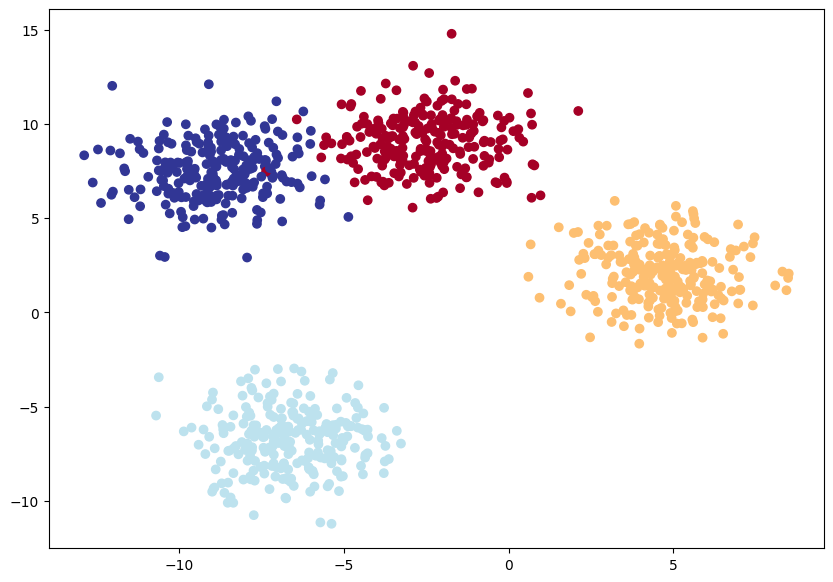

In [ ]:
# import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from torch import nn

# Set the hyperparameters for data creations
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multiclass data
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# turn data into tensors
X_blob =  torch.from_numpy(X_blob).type(torch.float)
y_blob =  torch.from_numpy(y_blob).type(torch.float)

#3. Split data into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# Make device agnostic mode
device = "cuda" if torch.cuda.is_available() else "cpu"

# Visualizing daya
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

In [ ]:
# Shape of data
print(X_blob_train.shape)
print(y_blob_train.shape)

torch.Size([800, 2])
torch.Size([800])


In [ ]:
torch.unique(y_blob_train)       # 4 output features

tensor([0., 1., 2., 3.])

In [ ]:
# Building a multiclass classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Creating an instance
model_0 = BlobModel(input_features=2,
                    output_features=4).to(device)
model_0.to(device)
model_0

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
# Create a loss function and an optimizer
loss_fn = nn.CrossEntropyLoss()                 # tip always use the pytorch website to read about the loss function before using it

optimizer = torch.optim.SGD(params=model_0.parameters(),
                   lr=0.01)

# Accuracy functon
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()  # Compare the true labels with predicted labels
  acc = (correct / len(y_pred)) * 100  # Calculate accuracy percentage
  return acc


### Getting prediction probabilities for a multiclass PyTorch model

In order to evaluate and train our model and test our model, we need to convert logits into predictions possibilities and then prediction labels

In [ ]:
# Lets get some raw outputs of our model
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_blob_test)
y_logits[:5]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])

In [ ]:
y_blob_test[:5]

tensor([1., 3., 2., 1., 0.])

In [ ]:
# converting logits to predictions
y_pred_probs = torch.softmax(y_logits, dim=1)          # Softmax is the same as sigmoid but it is used in MCC
y_pred_probs[:5]

tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])

In [ ]:
# Notice how the sum of the 4 prediction probabilities is 1 and the highest of them should be 0,1,2,3
# so the inpput will be in the blob of highest probabilities
torch.sum(y_pred_probs[0])

tensor(1.0000)

In [ ]:
# So to convert pred probs to prediction labels we use argmax
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

In [ ]:
y_blob_test       # The prediction labels and y_preds are now in the same format

tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0., 0., 1., 0., 0., 0., 3., 3., 2.,
        3., 3., 3., 0., 1., 2., 2., 2., 3., 0., 1., 0., 3., 1., 1., 3., 1., 2.,
        1., 3., 0., 2., 0., 3., 3., 2., 0., 3., 1., 1., 0., 3., 1., 0., 1., 1.,
        3., 2., 1., 1., 3., 2., 2., 0., 3., 2., 2., 0., 0., 3., 3., 0., 0., 3.,
        3., 3., 2., 3., 3., 3., 3., 1., 0., 2., 3., 2., 3., 3., 2., 3., 3., 2.,
        3., 3., 1., 3., 3., 3., 1., 0., 3., 2., 0., 0., 3., 0., 2., 3., 1., 0.,
        3., 2., 1., 1., 0., 2., 2., 3., 0., 0., 1., 2., 2., 3., 0., 1., 2., 0.,
        0., 0., 2., 3., 1., 2., 3., 2., 0., 3., 0., 0., 1., 1., 1., 0., 2., 2.,
        2., 2., 0., 3., 3., 2., 2., 1., 3., 2., 0., 0., 3., 3., 2., 1., 2., 0.,
        3., 2., 0., 3., 2., 0., 2., 2., 2., 0., 3., 1., 1., 1., 1., 1., 3., 1.,
        0., 2., 2., 1., 2., 2., 0., 1., 2., 2., 0., 0., 1., 3., 2., 0., 3., 1.,
        2., 1.])

## Creating the training and testing loop

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


epochs = 1000

# Data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range (epochs):
  # Training loop
  model_0.train()

  y_logits = model_0(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train.type(torch.long))                  # cross entropy acts with torch.long instead of torch.float
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()
  optimizer.step()

  # Test loop
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_blob_test).squeeze()
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test.type(torch.long))
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)

    # Print the metrics
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | loss: {loss:.4f}% | acc:{acc:.2f}% | Test loss : {test_loss:.4f}% | test acc: {test_acc:.2f}")





Epoch: 0 | loss: 0.2338% | acc:99.25% | Test loss : 0.2406% | test acc: 99.50
Epoch: 100 | loss: 0.1029% | acc:99.25% | Test loss : 0.1000% | test acc: 99.50
Epoch: 200 | loss: 0.0644% | acc:99.25% | Test loss : 0.0587% | test acc: 99.50
Epoch: 300 | loss: 0.0501% | acc:99.25% | Test loss : 0.0433% | test acc: 99.50
Epoch: 400 | loss: 0.0428% | acc:99.25% | Test loss : 0.0353% | test acc: 99.50
Epoch: 500 | loss: 0.0383% | acc:99.25% | Test loss : 0.0301% | test acc: 99.50
Epoch: 600 | loss: 0.0352% | acc:99.25% | Test loss : 0.0268% | test acc: 99.50
Epoch: 700 | loss: 0.0331% | acc:99.25% | Test loss : 0.0245% | test acc: 99.50
Epoch: 800 | loss: 0.0316% | acc:99.25% | Test loss : 0.0228% | test acc: 99.50
Epoch: 900 | loss: 0.0305% | acc:99.25% | Test loss : 0.0214% | test acc: 99.50


In [ ]:
# Make predictions
model_0.eval
with torch.inference_mode():
  y_logits = model_0(X_blob_test)

y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = torch.argmax(y_logits, dim=1)
y_preds[:10]


tensor([1., 0., 2., 2., 0., 0., 0., 1., 3., 0.])

In [ ]:
y_blob_train[:10]

tensor([1., 0., 2., 2., 0., 0., 0., 1., 3., 0.])

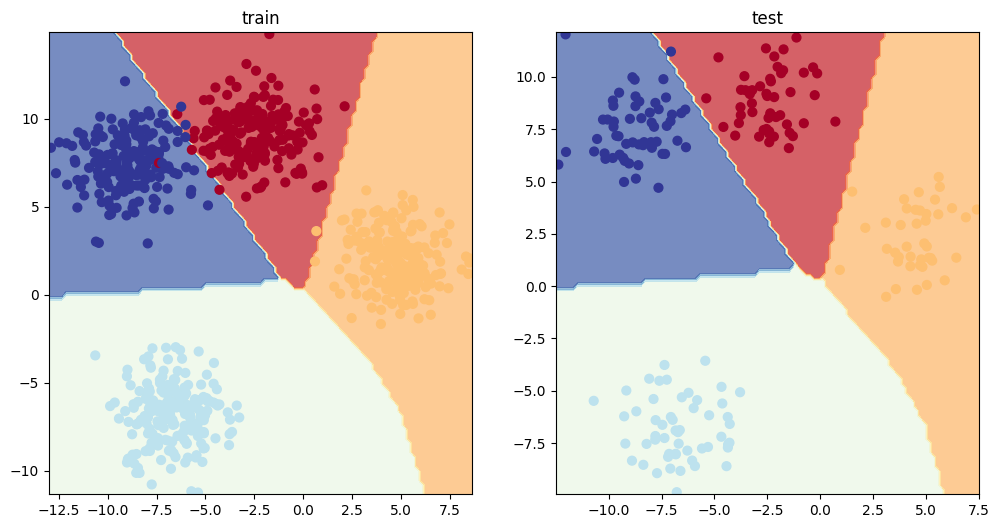

In [ ]:
# now plotting decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_0, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_0, X_blob_test, y_blob_test)

 This data can also be separated by straight lines so we can also do this without introducing non-linearity or ReLU

## Some more evaluation metrics
* accuracy
* precision
* Recall
* f1 score
* confusion matrix
* classification report